In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

from scipy import interpolate

In [5]:
def convert_to_cylindrical(coordinate,velocity,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0]):
    #convert a 3 element matrix into a matrix of spherical coordinates
    #I could calculate V_tan and then project it into the new xy plane

    #it also could just be cylindrical and just use V_theta
    #just do cylindrical

    #the basic formula for converting velocities from cartesian to cylindrical is
    #
    # v = (x*dx/dt+y*dy/dt)/r rhat + (x*dy/dt-y*dx/dt)/r thetahat + dz/dt zhat

    import numpy as np

    halo_center = np.asarray(halo_center)
    halo_vel = np.asarray(halo_vel)

    X = np.asarray(coordinate[:,0])-halo_center[0]
    Y = np.asarray(coordinate[:,1])-halo_center[1]
    Z = np.asarray(coordinate[:,2])-halo_center[2]

    VX = np.asarray(velocity[:,0])-halo_vel[0]
    VY = np.asarray(velocity[:,1])-halo_vel[1]
    VZ = np.asarray(velocity[:,2])-halo_vel[2]

    R = np.sqrt(X**2.0+Y**2.0)
    theta = np.arctan2(Y,X)

    D_cylindrical = np.zeros((len(R),3))
    D_cylindrical[:,0] = R
    D_cylindrical[:,1] = theta
    D_cylindrical[:,2] = Z

    Vr = (X*VX+Y*VY)/R
    Vtheta = (X*VY-Y*VX)/R
    Vz = VZ

    V_cylindrical = np.zeros((len(Vr),3))
    V_cylindrical[:,0] = Vr
    V_cylindrical[:,1] = Vtheta
    V_cylindrical[:,2] = Vz

    return D_cylindrical, V_cylindrical

def Calc_average_L_shift(coordinates,masses,velocities):
    #For already shifted and cut cordinates
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    coord_mod = coordinates
    mass_mod = masses
    vel_mod = velocities

    coord_shift = coord_mod
    vel_shift = vel_mod

    rcrossv = np.cross(coord_shift,vel_shift)
    L_vec = [mass_mod[ii]*rcrossv[ii] for ii in range(len(rcrossv))]

    L_avg = np.mean(L_vec,axis=0)
    den = np.sqrt(L_avg[0]**2.0+L_avg[1]**2.0+L_avg[2]**2.0)
    return L_avg/den

def Rotate_to_z_axis(coordinates,velocities,rotation_axis):
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance
    #Okay I want to take in a "z" axis, and then rotate the
    #coordinates so that that is the z axis
    #then calculate velocity vectors in that frame and
    #then decompose it into spherical coordinates IN THAT FRAME

    L = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0+rotation_axis[2]**2.0) #total length
    R = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0) #length in xy plane
    
    ####OLD ROTATION MATRICIES#####
    R1 = np.asarray([[rotation_axis[0]/R,rotation_axis[1]/R,0.0],[-rotation_axis[1]/R,rotation_axis[0]/R,0.0],[0.0,0.0,1.0]]) #rotation about z axis to project into xz plane
    R2 = np.asarray([[rotation_axis[2]/L,0.0,-R/L],[0.0,1.0,0.0],[R/L,0.0,rotation_axis[2]/L]]) #rotation about y axis to make given axis the z axis
    
    #apply rotation to coordinates and velocities
    
    coord_rotate = np.asarray([R2.dot(R1.dot(xx)) for xx in coordinates])
    vel_rotate = np.asarray([R2.dot(R1.dot(xx)) for xx in velocities])

    return coord_rotate, vel_rotate

def principle_axes(coordinates,masses,rad,center=None):
    #This code calculates principle axes of a given star particle
    #This is basically a modified version of Andrew Wetzel's code
    #to do the same thing
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    if center == None:
        dm_dist_val = np.linalg.norm(coordinates,axis=1)
    else:    
        dm_dist_val = get_distance(coordinates, center)

    dist_mask = (dm_dist_val<=rad)
    coord_mod = coordinates[dist_mask]
    mass_mod = masses[dist_mask]
    
    if center == None:
        dm_dist = coord_mod
    else:
        dm_dist = get_distance_vector(coord_mod, center)
    
    weights = mass_mod/np.median(mass_mod)

    xx = np.sum(weights * dm_dist[:,0]**2.0)
    yy = np.sum(weights * dm_dist[:,1]**2.0)
    zz = np.sum(weights * dm_dist[:,2]**2.0)
    
    xy = yx = np.sum(weights * dm_dist[:,0] * dm_dist[:,1])
    xz = zx = np.sum(weights * dm_dist[:,0] * dm_dist[:,2])
    yz = zy = np.sum(weights * dm_dist[:,1] * dm_dist[:,2])
    
    I_tensor = [[xx, xy, xz],[yx, yy, yz],[zx, zy, zz]]

    eigen_values, eigen_vectors = np.linalg.eig(I_tensor)

    # order eigen-vectors by eigen-values, from largest to smallest                                  
    eigen_indices_sorted = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[eigen_indices_sorted]
    eigen_values /= eigen_values.max()  # renormalize to 1                                           
    # make eigen_vectors[0] corresponds to vector of eigen_values[0]                                 
    eigen_vectors = eigen_vectors.transpose()[eigen_indices_sorted]

    axis_ratios = np.sqrt(
        [eigen_values[2] / eigen_values[0],
         eigen_values[2] / eigen_values[1],
         eigen_values[1] / eigen_values[0]]
    )

    return eigen_values, eigen_vectors, axis_ratios

In [7]:
#The correlation program is busted for reason that I don't quite understand
#as far as I can tell it has to be one of 3 things
#
# 1) a problem with the input particles either stars or dm
# 2) a problem with the NN algorithms
# 3) a problem with the sorting algorithms
#
# 1 is easy to check I just need to load up the particle data and plot it to see if it
# looks okay:

#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo_train = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

h = 0.702

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

f_parts = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.hdf5')

f_stars = f_parts['PartType4']

star_coords = f_stars['Coordinates'][:]/h
star_vel = f_stars['Velocities'][:]
star_mass = f_stars['Masses'][:]*1.0e10/h

f_gas = f_parts['PartType0']

gas_coords = f_gas['Coordinates'][:]/h
gas_vel = f_gas['Velocities'][:]
gas_mass = f_gas['Masses'][:]*1.0e10/h

f_dm = f_parts['PartType1']

dm_coords = f_dm['Coordinates'][:]/h
dm_mass = f_dm['Masses'][:]*1.0e10/h


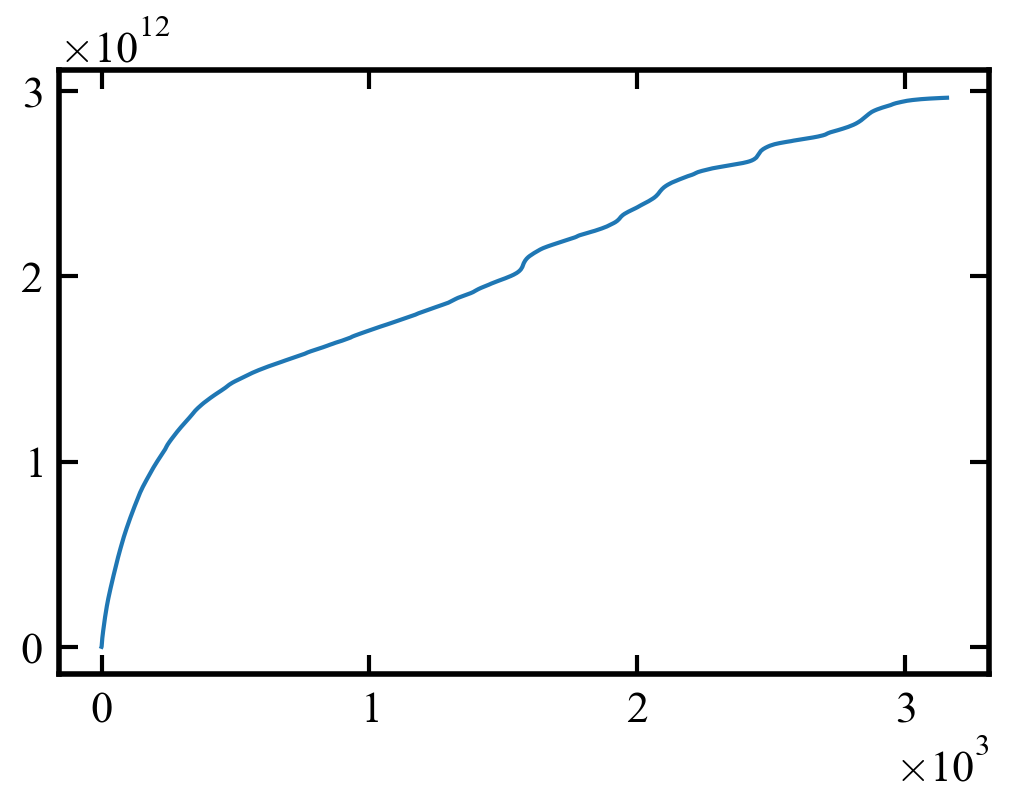

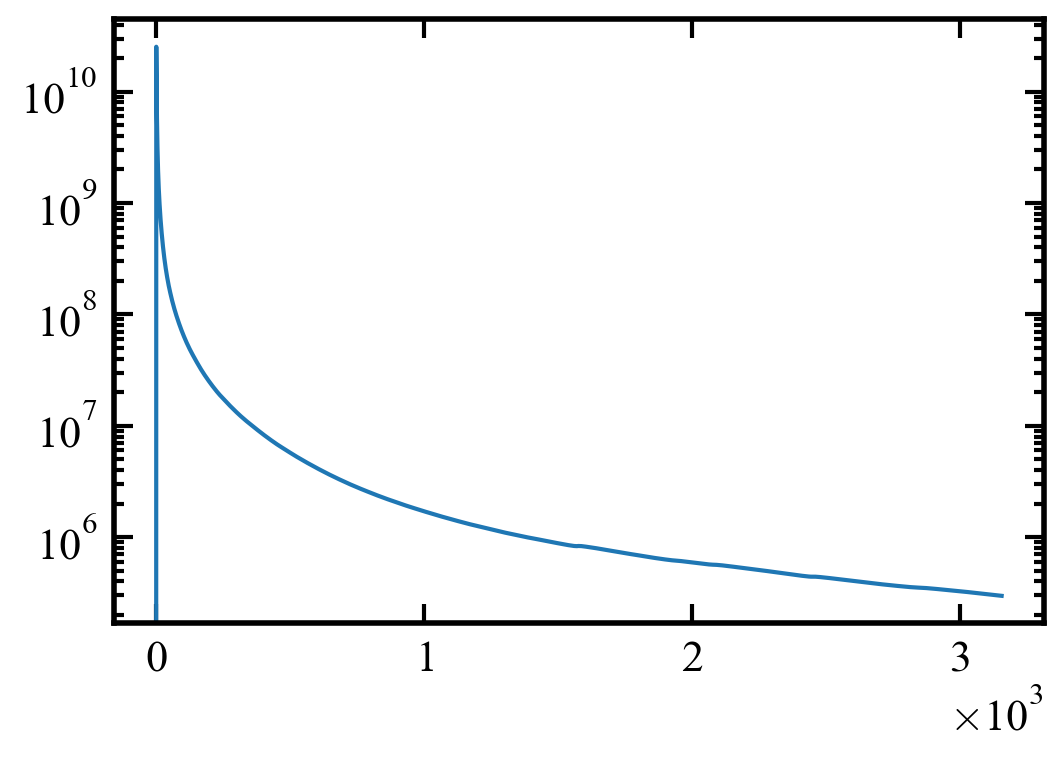

In [14]:
#first center coordinates 
coord_diff = star_coords-host_pos_train
coord_diff_gas = gas_coords-host_pos_train
coord_diff_dm = dm_coords-host_pos_train

vel_diff = star_vel - host_vel_train

dist = np.linalg.norm(coord_diff,axis=1)
dist_gas =np.linalg.norm(coord_diff_gas,axis=1)
dist_dm =np.linalg.norm(coord_diff_dm,axis=1)

#m_prof_bins = np.linspace(0.0,1000.0,5000)
m_prof_bins = np.logspace(-4.0,3.5,5000)

mass_profile_c, mpbins = np.histogram(dist,weights=star_mass,bins=m_prof_bins)
mass_profile_gas_c, mpbins  = np.histogram(dist_gas,weights=gas_mass,bins=m_prof_bins)
mass_profile_dm_c, mpbins  = np.histogram(dist_dm,weights=dm_mass,bins=m_prof_bins)

mass_profile_total_c = np.sum([np.cumsum(mass_profile_c),
                               np.cumsum(mass_profile_gas_c),
                               np.cumsum(mass_profile_dm_c)],axis=0)

m_prof_bins_plot = np.array([(m_prof_bins[ii]+m_prof_bins[ii+1])/2.0 for ii in 
                             range(len(m_prof_bins)-1)])

force_grav = np.divide(mass_profile_total_c,m_prof_bins_plot*m_prof_bins_plot)

plt.plot(m_prof_bins_plot,mass_profile_total_c)
plt.show()

plt.plot(m_prof_bins_plot,force_grav)
plt.yscale('log')
plt.show()

In [15]:
#do the interpolation

mass_profile_interp = interpolate.interp1d(m_prof_bins_plot,mass_profile_total_c)

In [16]:
import scipy.integrate as integrate
from scipy.optimize import fsolve


#solve for the energy of a particle
coord_test = np.linalg.norm(coord_diff[0])
vel_test = np.linalg.norm(vel_diff[0])

KE = 0.5*vel_test**2.0 #in km^2/s^2

G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1

PE = G * integrate.quad(lambda x: mass_profile_interp(x)/x**2.0, coord_test, 999.0, limit=250)[0]

E_i = KE+PE

func = lambda x : E_i - G * (mass_profile_interp(x)/(2.0*x) - 
                             integrate.quad(lambda k: mass_profile_interp(k)/k**2.0, x, 999.0, 
                                            limit=250)[0])

r_c = fsolve(func,coord_test)

print coord_test
print r_c

j_c = np.sqrt(G * mass_profile_interp(r_c)/r_c)

print np.linalg.norm(np.cross(coord_diff[0],vel_diff[0]))
print j_c

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


9.571645574156491
[11.00370591]
1861.2601760980715
[233.23691957]


In [18]:
print m_prof_bins_plot[0]
mass_profile_interp(0.0+1.0e-3)

0.00010017302712261232


array(0.)

In [19]:
galaxy_mask = (dist<50.0)
print np.sum(galaxy_mask)

12490729


[-0.25230393 -0.00831013 -0.96761235]


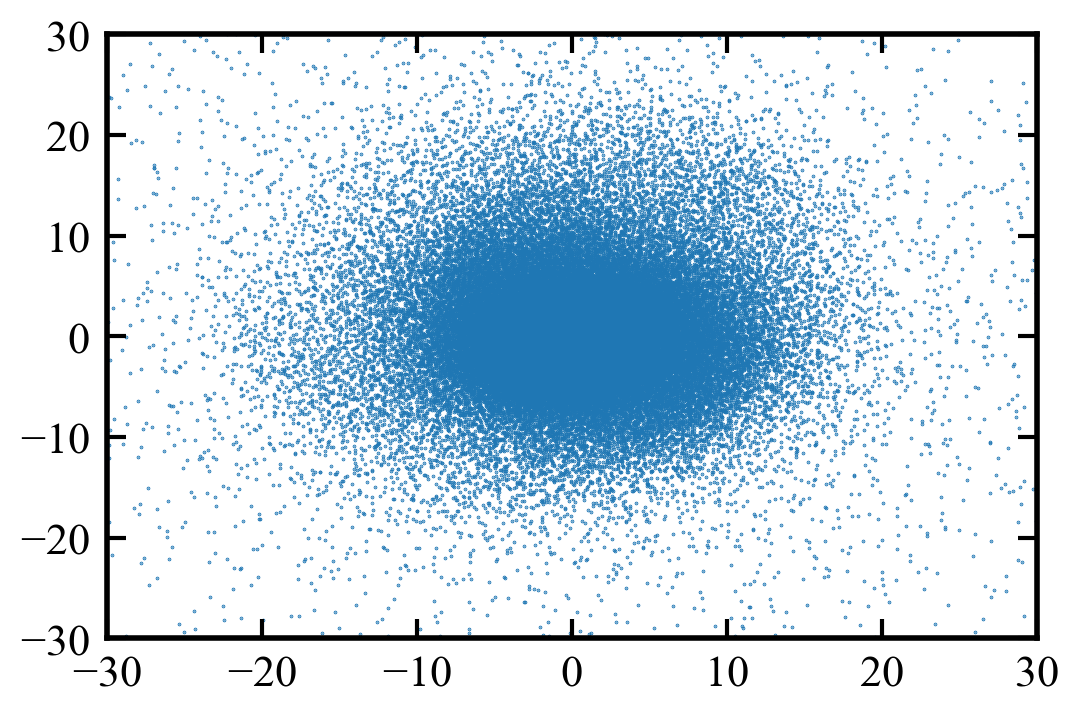

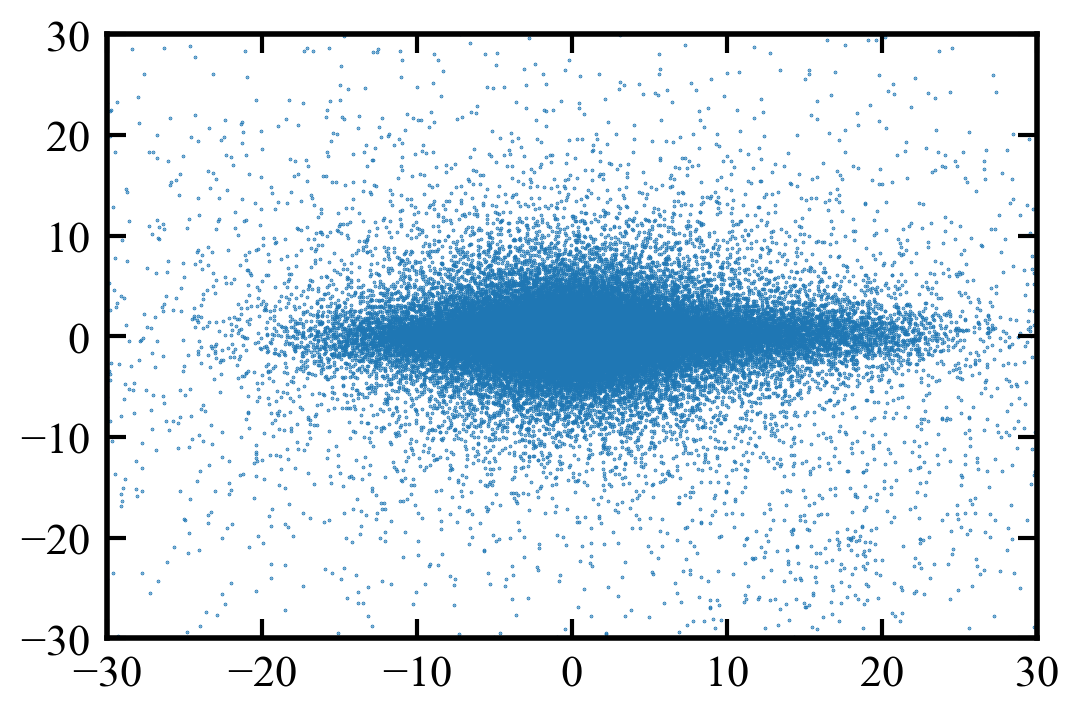

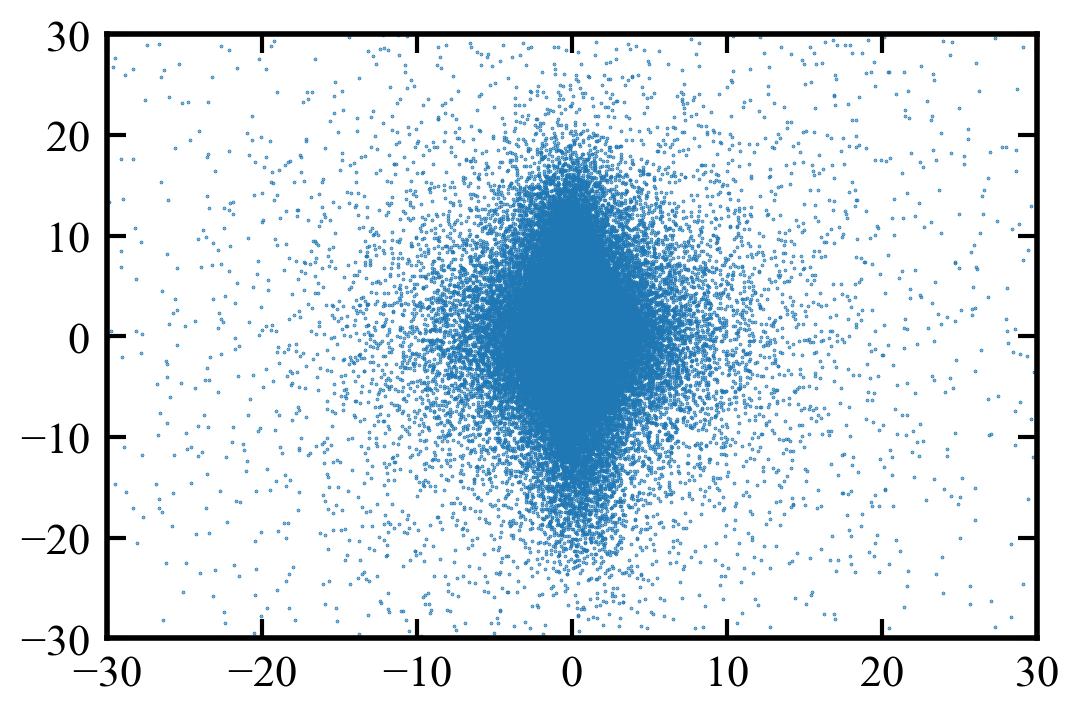

In [21]:
#Find the angular momentum vector and then rotate to that vector

#first center coordinates 
coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist = np.linalg.norm(coord_diff,axis=1)
galaxy_mask = (dist<20.0)

L_vec =  Calc_average_L_shift(coord_diff[galaxy_mask],star_mass[galaxy_mask],vel_diff[galaxy_mask])

part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,L_vec)

coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

print L_vec

plt.scatter(part_rotate[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,0][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


In [67]:
coord_select = 1.0

print E_i

print m_prof_bins

r_c = fsolve(func,coord_select)

-91570.40311752298
[1.00000000e-04 1.00346054e-04 1.00693306e-04 ... 3.14050435e+03
 3.15137220e+03 3.16227766e+03]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


ValueError: A value in x_new is above the interpolation range.

In [68]:
#now it should be relatively easy to calculate the z component of the angular momentum
#just calculate r x v for the rotated particles and then take the z component

galaxy_mask = (dist<50.0)

coord_diff_gal = coord_diff[galaxy_mask]
vel_diff_gal = vel_diff[galaxy_mask]


ang_mom_rotated = np.cross(part_rotate,vel_rotate,axis=1) #kpc*km/s

ang_mom_rotated_gal = ang_mom_rotated[galaxy_mask]

G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1

j_c_list, ang_mom_list = [], []

print('beginning loop')

for ii in range(len(coord_diff_gal))[::10000]:
    coord_select = np.linalg.norm(coord_diff_gal[ii])
    vel_select = np.linalg.norm(vel_diff_gal[ii])
    j_z = ang_mom_rotated_gal[ii]
    
    KE = 0.5*vel_select**2.0 #in km^2/s^2
    PE = -1.0 * G * integrate.quad(lambda x: mass_profile_interp(x+1.0e-3)/x**2.0,
                                   coord_select, 999.0, limit=250)[0]
    
    E_i = KE+PE
    
    if coord_select<0.0:
        print('There is a problem here, distance is {}'.format(coord_select))
        
    func = lambda x : E_i - G * (mass_profile_interp(x)/(2.0*x) -
                             integrate.quad(lambda k: mass_profile_interp(abs(k)+1.0e-3)/(k+1.0e-3)**2.0, x, 999.0, 
                                            limit=250)[0])
    
    try:
        r_c = fsolve(func,coord_select)
        j_c = np.sqrt(G * mass_profile_interp(r_c)*r_c) #km/s??
        j_c_list.append(j_c)
        ang_mom_list.append(j_z)
        
    except ValueError:
        print(coord_select,vel_select)
        continue
    
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)

print len(ang_mom_rotated_gal[2]), len(j_c_list)

epsilon = np.divide(ang_mom_list,j_c_list)

beginning loop


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


3 1250


In [59]:
print ang_mom_list, j_c_list

[] []


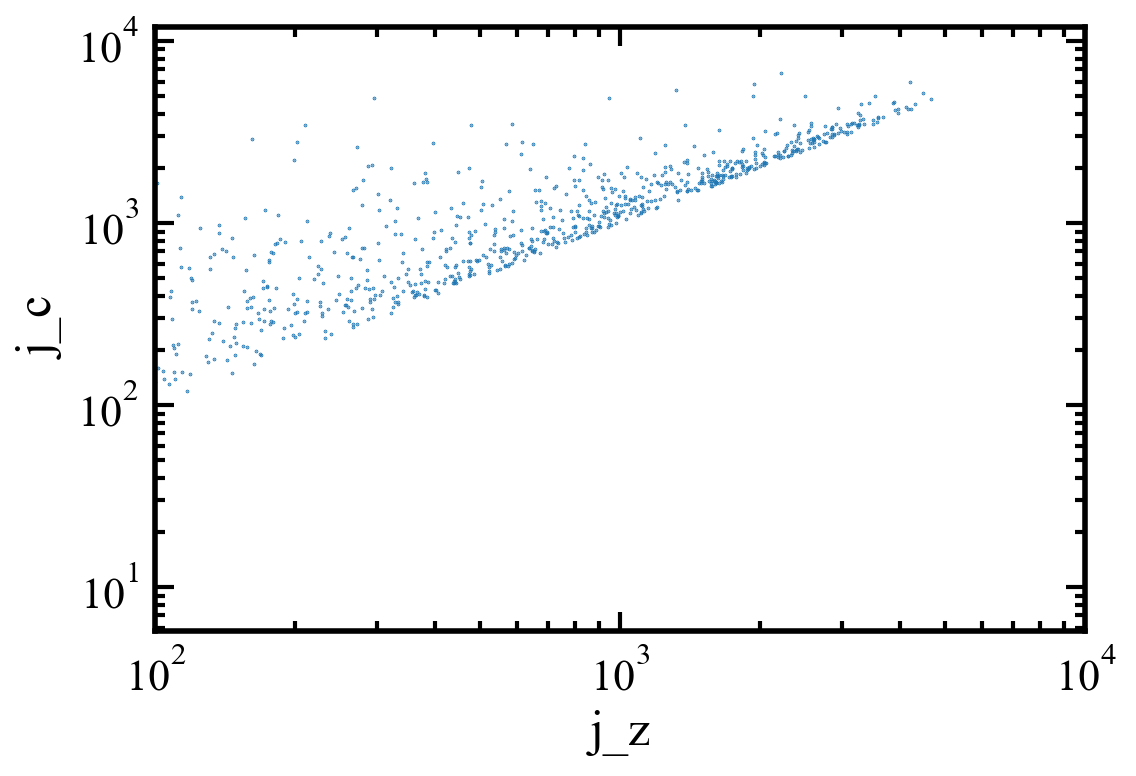

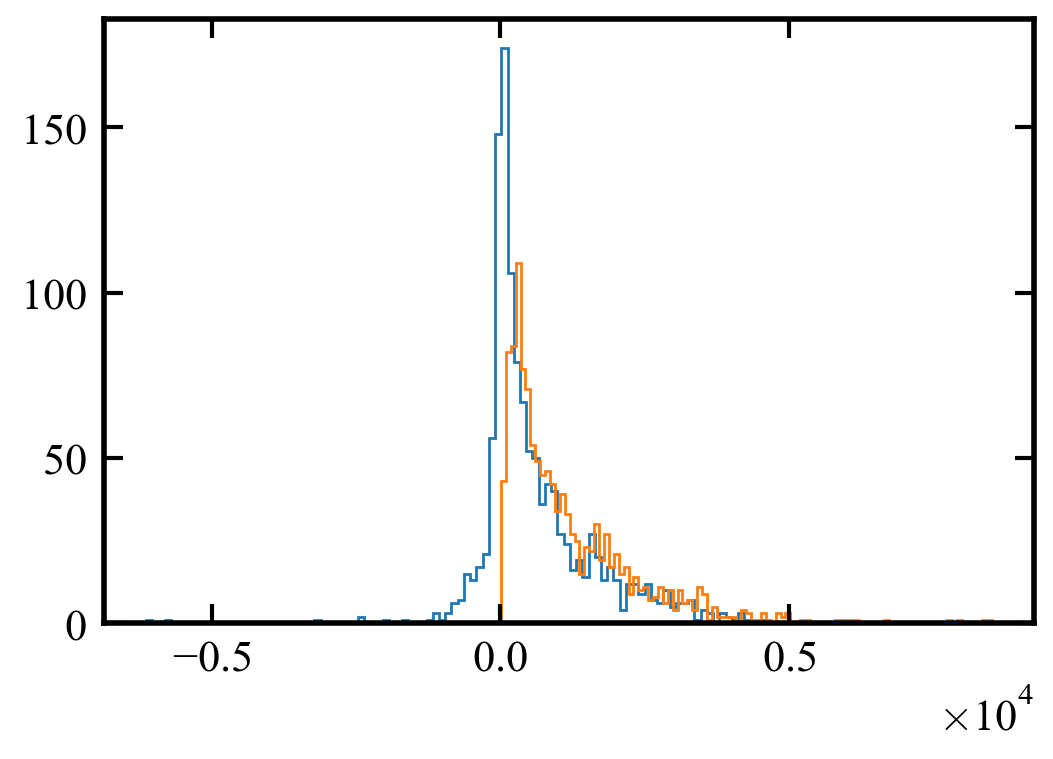

In [69]:
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)

plt.scatter(ang_mom_list[:,2],np.ndarray.flatten(j_c_list),s = 0.1)
plt.xlabel('j_z')
plt.ylabel('j_c')
plt.xscale('log')
plt.yscale('log')
plt.xlim([100.0,1.0e4])
plt.show()

plt.hist(ang_mom_list[:,2],bins=100,histtype='step')
plt.hist(np.ndarray.flatten(j_c_list),bins=100,histtype='step')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim([100.0,1.0e4])
plt.show()

[-137.91115535  -18.94994328 1734.73162443]
[1950.27793541 1137.72015759 1404.64945523 ...  402.77757226 1799.35163318
 3176.95407617]
[1830.85725574 1050.00209885  841.5421089  ... -207.42579795 1107.55541572
 2536.90852816]
0.9974499274777855


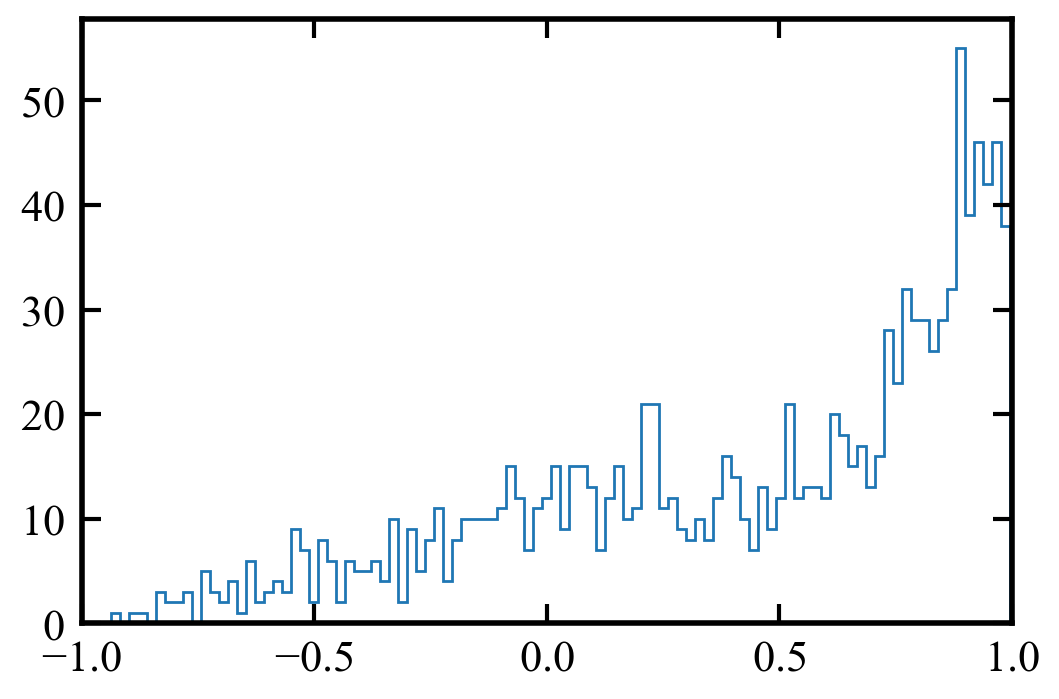

In [72]:
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)

print ang_mom_rotated_gal[2]
print np.ndarray.flatten(j_c_list)

epsilon = np.divide(ang_mom_list[:,2],np.ndarray.flatten(j_c_list))

print ang_mom_list[:,2]

print np.max(epsilon)

plt.hist(epsilon,bins=100,histtype='step')
plt.xlim([-1.0,1.0])
plt.show()

[-0.25230393 -0.00831013 -0.96761235]


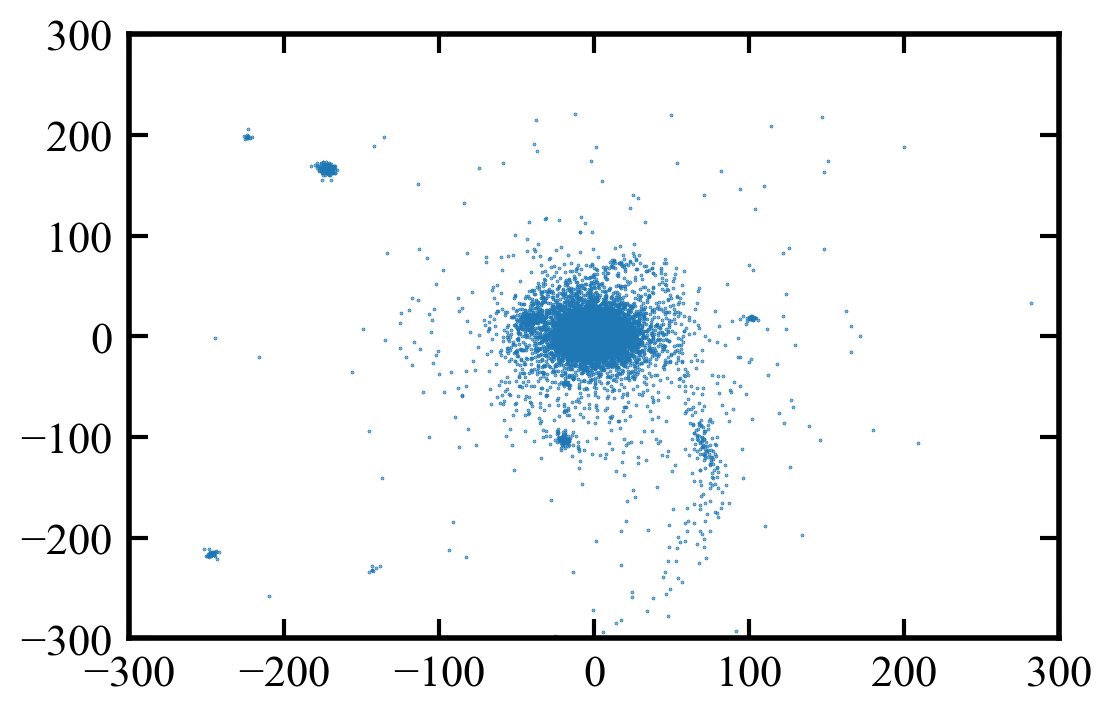

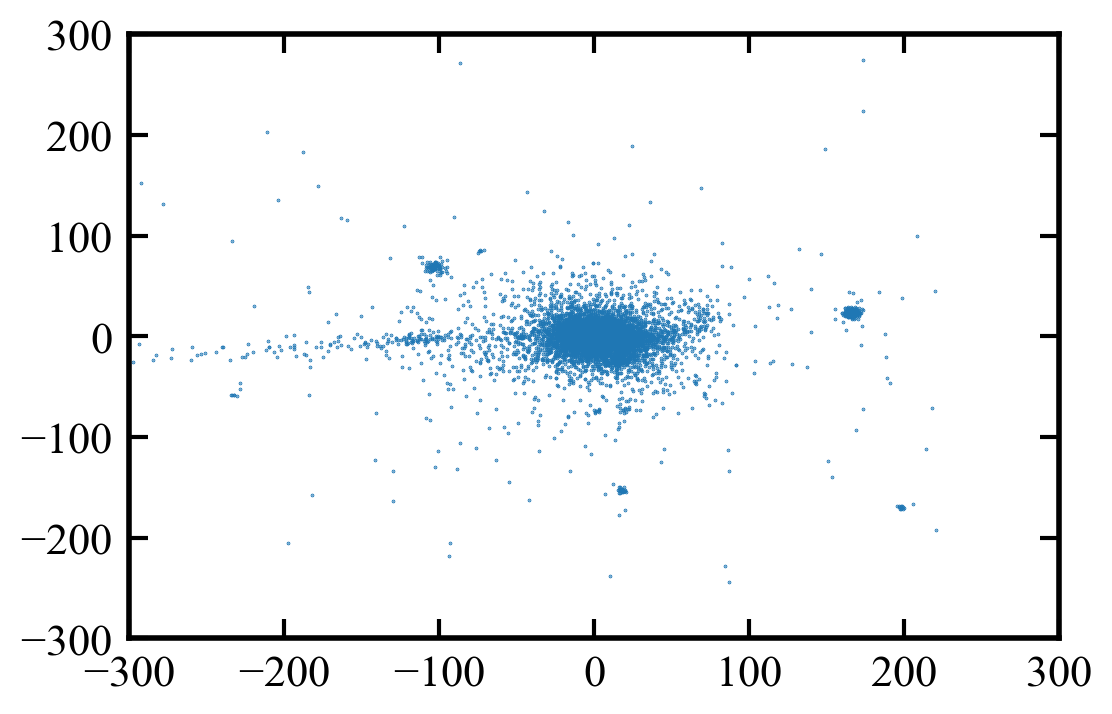

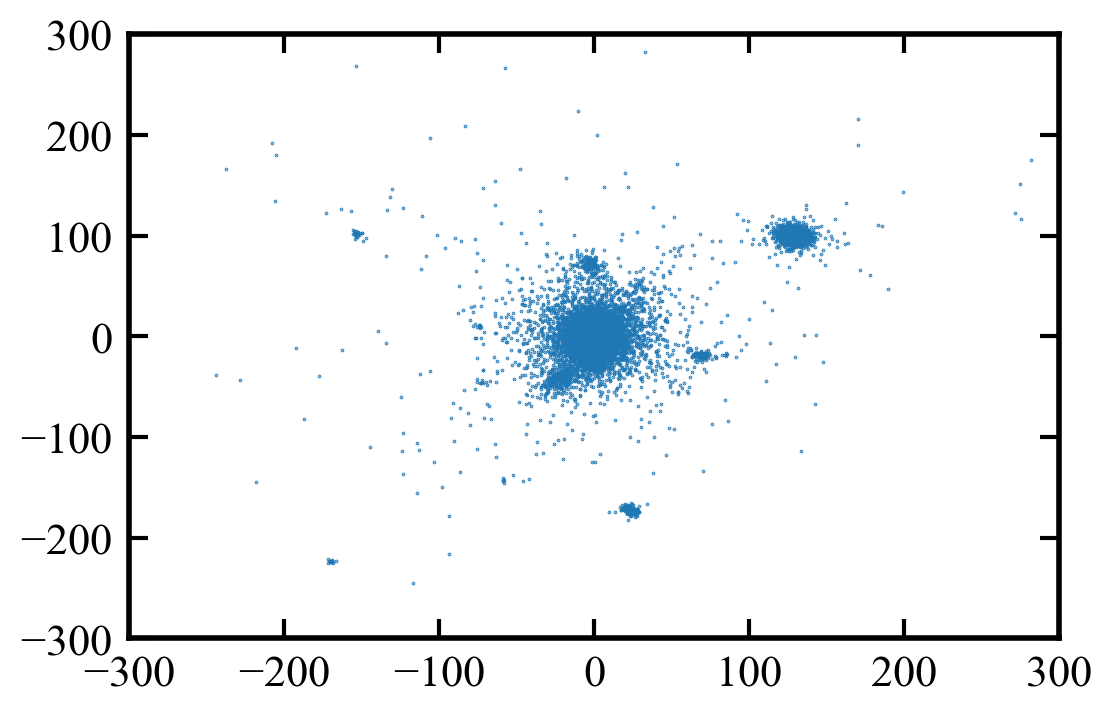

In [58]:
#Find the angular momentum vector and then rotate to that vector

#first center coordinates 
coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist = np.linalg.norm(coord_diff,axis=1)
galaxy_mask = (dist<20.0)

L_vec =  Calc_average_L_shift(coord_diff[galaxy_mask],star_mass[galaxy_mask],vel_diff[galaxy_mask])

part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,L_vec)

coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

print L_vec

plt.scatter(part_rotate[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,0][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


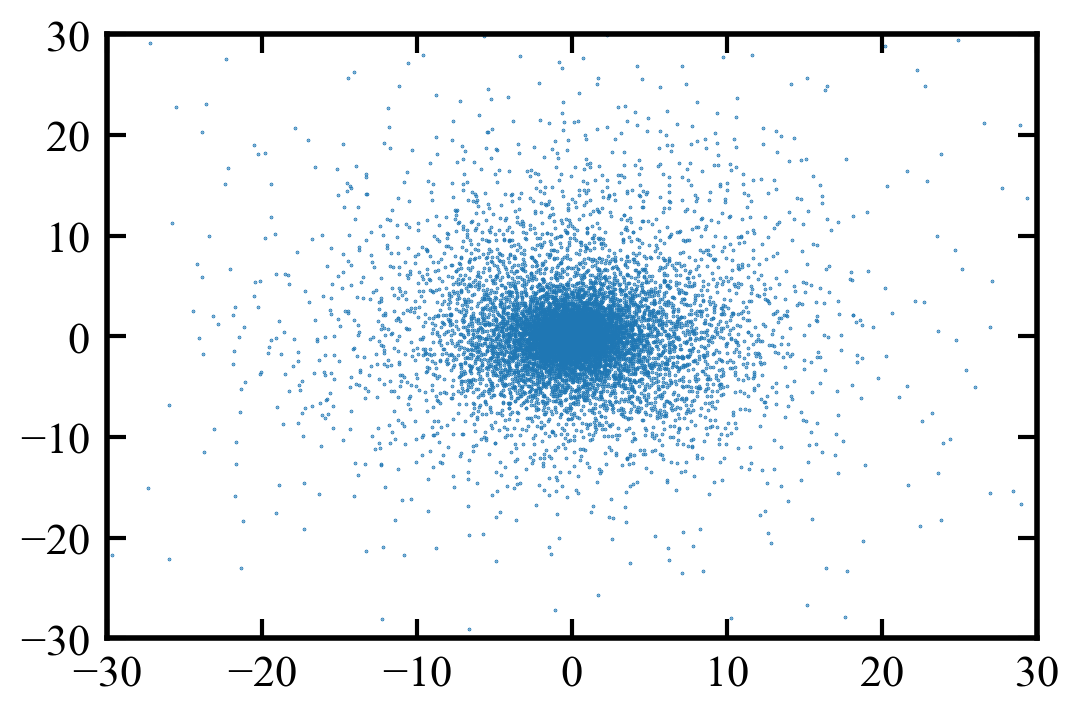

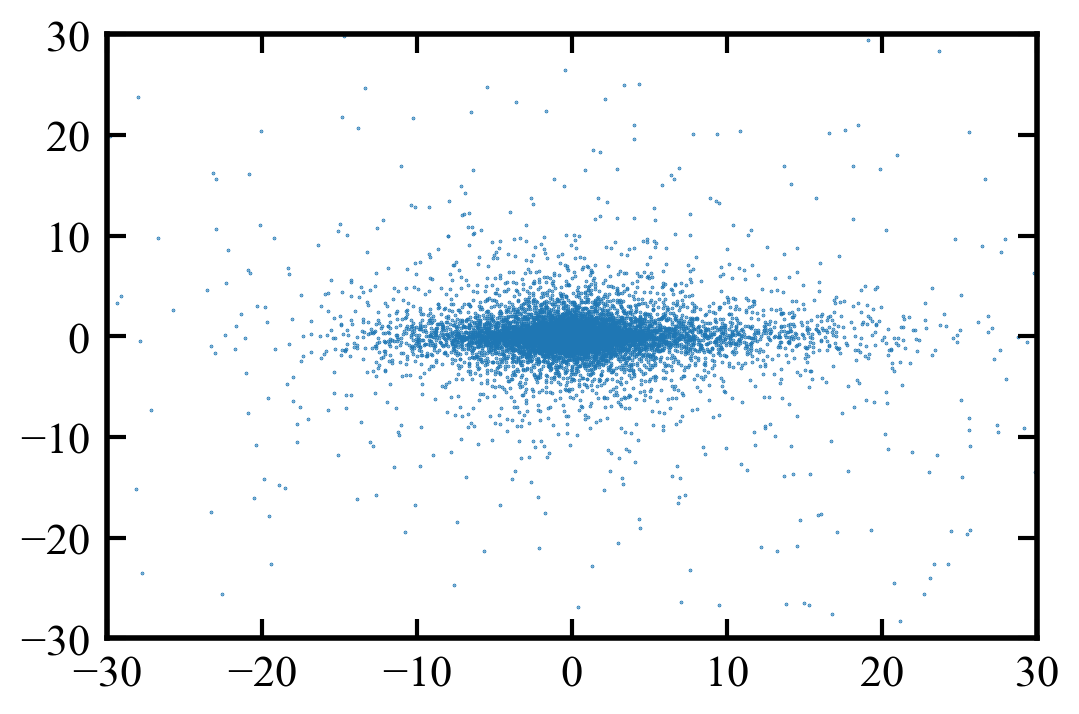

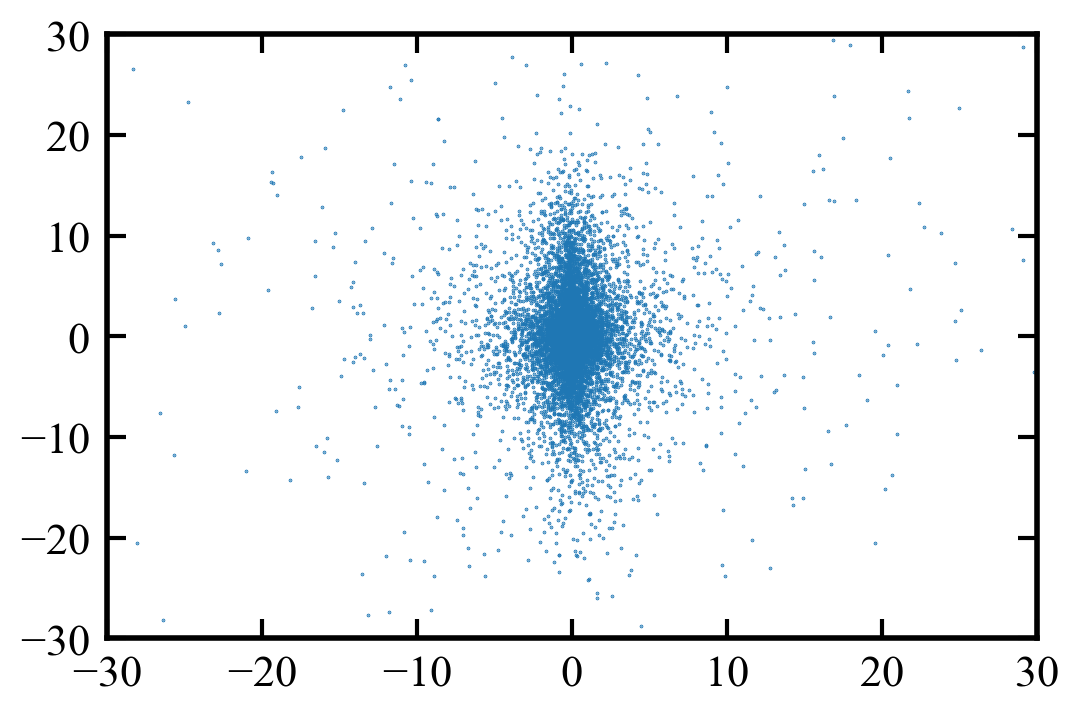

In [61]:
plt.scatter(part_rotate[:,0][::1000],part_rotate[:,1][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::1000],part_rotate[:,2][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::1000],part_rotate[:,0][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

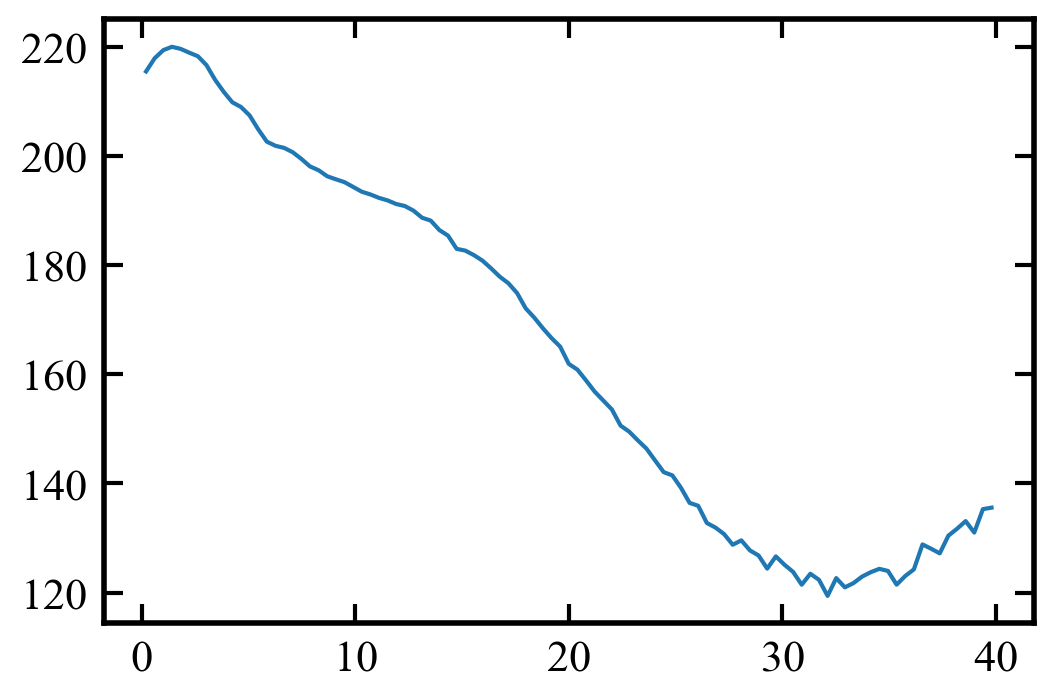

In [68]:
R_xy = coord_cyl_disk[:,0]
v_phi = np.sqrt(vel_rotate[:,0]**2.0+vel_rotate[:,1]**2.0)

r_bins = np.linspace(0.0,40.0,100)

R_list,v_list = [],[]

for ii in range(len(r_bins)-1):
    bin_mask = (R_xy>=r_bins[ii])&(R_xy<r_bins[ii+1])
    R_list.append((r_bins[ii]+r_bins[ii+1])/2.0)
    v_list.append(np.mean(v_phi[bin_mask]))
    
plt.plot(R_list,v_list)
plt.show()


In [ ]:
#for a given particle I need to do the integral over the interpolation function to get M(<r)



In [ ]:
#now it should be relatively easy to calculate the z component of the angular momentum
#just calculate r x v for the rotated particles and then take the z component

ang_mom_rotated = np.cross(part_rotate,vel_rotate,axis=1)



[-0.24233836  0.01721632 -0.97003903]


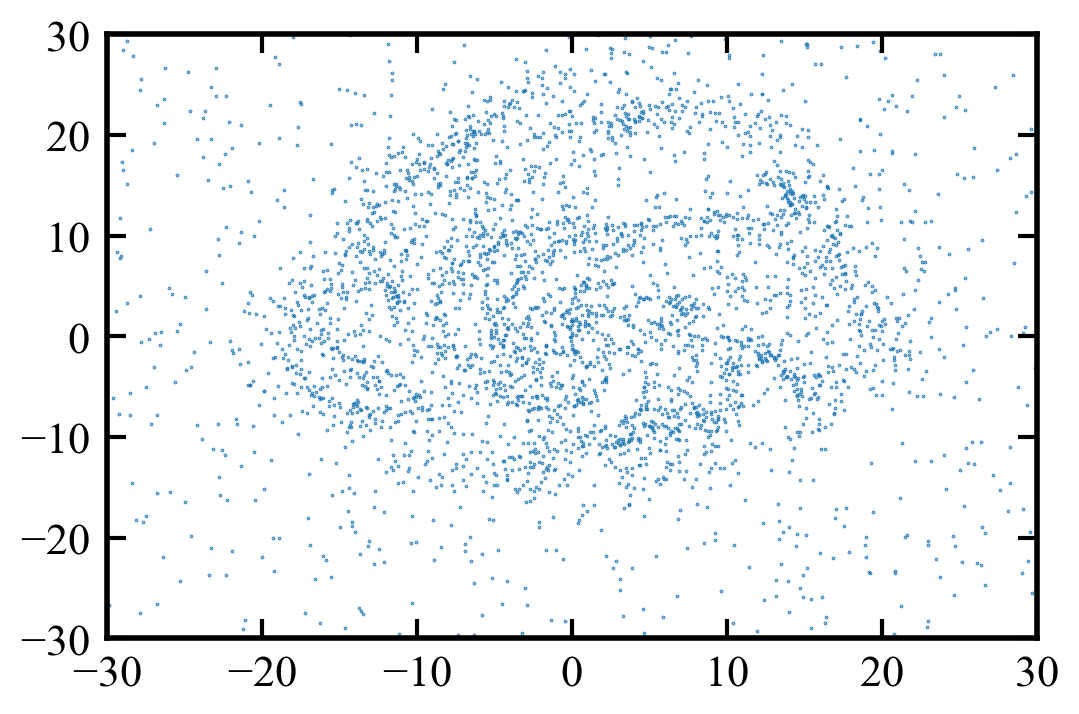

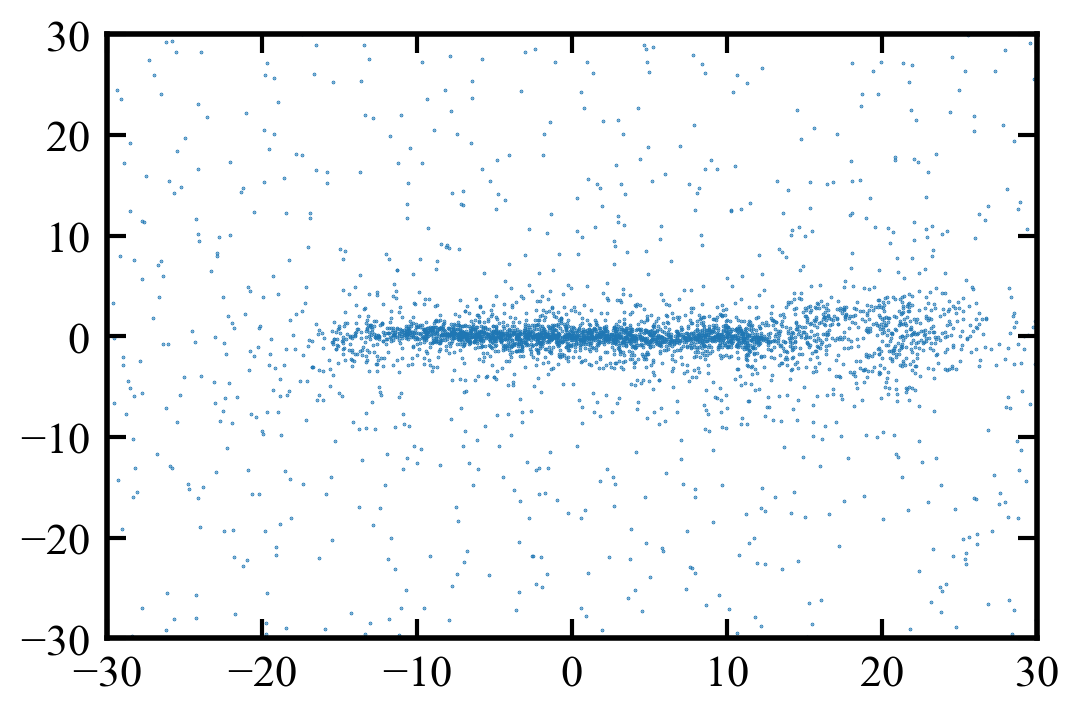

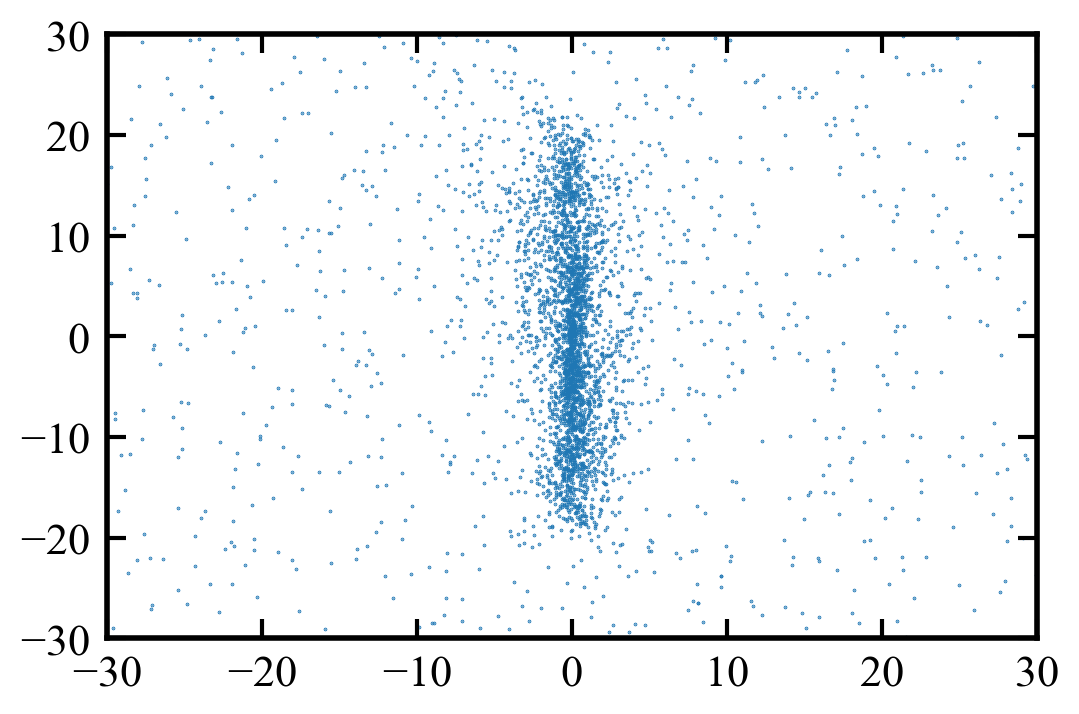

In [73]:
#Do ang mom for the gas

#first center coordinates 
coord_diff_gas = gas_coords-host_pos_train
vel_diff_gas = gas_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist_gas = np.linalg.norm(coord_diff_gas,axis=1)
galaxy_mask_gas = (dist_gas<20.0)

L_vec_gas =  Calc_average_L_shift(coord_diff_gas[galaxy_mask_gas],
                                  gas_mass[galaxy_mask_gas],
                                  vel_diff_gas[galaxy_mask_gas])

part_rotate_gas, vel_rotate_gas =  Rotate_to_z_axis(coord_diff_gas,vel_diff_gas,L_vec_gas)

coord_cyl_disk_gas, vel_cyl_disk_gas = convert_to_cylindrical(part_rotate_gas,vel_rotate_gas)

print L_vec_gas

plt.scatter(part_rotate_gas[:,0][::1000],part_rotate_gas[:,1][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate_gas[:,1][::1000],part_rotate_gas[:,2][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate_gas[:,2][::1000],part_rotate_gas[:,0][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


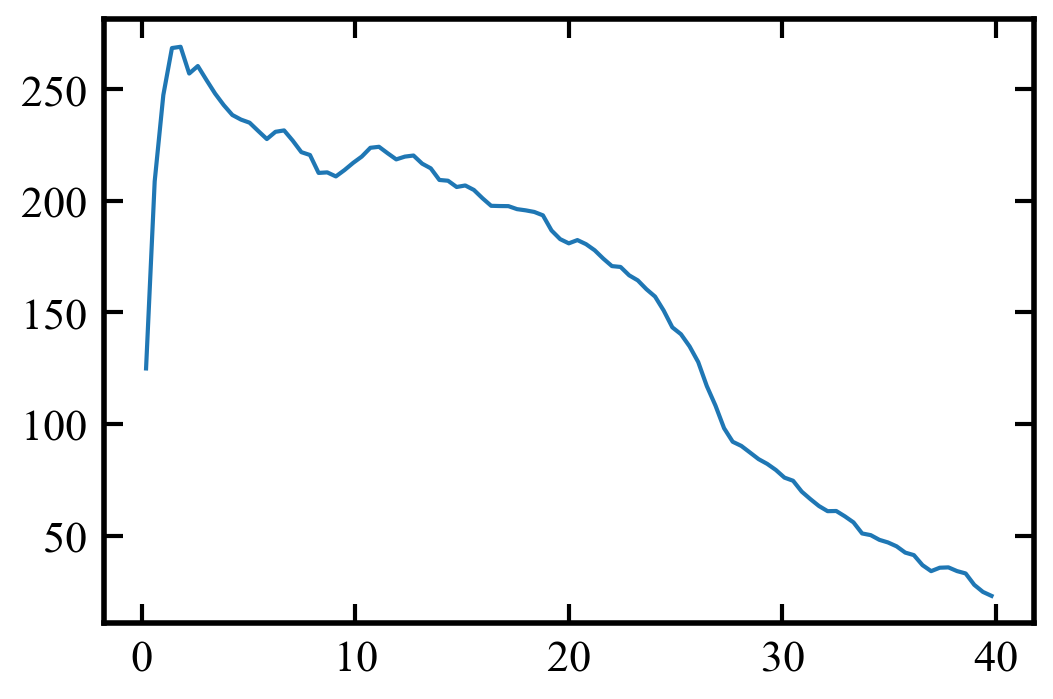

In [82]:
#gas rotation curve

R_xy_gas = coord_cyl_disk_gas[:,0]
#v_phi_gas = np.sqrt(vel_rotate_gas[:,0]**2.0+vel_rotate_gas[:,1]**2.0)
v_phi_gas = vel_cyl_disk_gas[:,1]

z_mask = (coord_cyl_disk_gas[:,2]<5.0)

#print v_phi_gas.shape, coord_cyl_disk_gas[:,2].shape

r_bins = np.linspace(0.0,40.0,100)

R_list_gas,v_list_gas = [],[]

for ii in range(len(r_bins)-1):
    bin_mask = (R_xy_gas>=r_bins[ii])&(R_xy_gas<r_bins[ii+1])
    R_list_gas.append((r_bins[ii]+r_bins[ii+1])/2.0)
    v_list_gas.append(np.mean(v_phi_gas[bin_mask&z_mask]))
    
plt.plot(R_list_gas,v_list_gas)
plt.show()


In [88]:
a = np.array([1.0,2.0,3.0])
b = np.array([1.0,2.0,3.0])
c = np.array([1.0,2.0,3.0])

np.sum([a,b,c],axis=0)

array([3., 6., 9.])